In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/MuraDataset')

In [3]:
# pip install pretrainedmodels
# import pretrainedmodels

In [4]:
# model_name = 'senet154' 
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')


In [5]:
!pip install scikit-plot

In [6]:
import os
import shutil
import sys
import time
import itertools

import numpy as np
import torch
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import scikitplot as skplt
from torch.autograd import Variable
from torch.backends import cudnn
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader,WeightedRandomSampler
from torchvision.datasets import ImageFolder
# plt.switch_backend('agg')

# sys.path.append('./')



In [7]:
from sklearn.metrics import cohen_kappa_score

In [8]:
"""
ResNet code gently borrowed from
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [9]:
model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=1000)

In [10]:
model_path = '/content/drive/MyDrive/MuraDataset/model/senet154-c7b49a05.pth'
state_dict = torch.load('/content/drive/MyDrive/MuraDataset/model/senet154-c7b49a05.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
global best_acc
best_acc = 0.0
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [12]:
def get_class_distribution(dataset_obj):

    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict


In [13]:
def add_prefix(prefix, path):
    return os.path.join(prefix, path)

In [14]:
def train(train_loader, model, optimizer, criterion, epoch):
    model.train(True)
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for idx, (inputs, labels) in enumerate(train_loader):
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        loss = Variable(loss,requires_grad = True) 
        loss.backward()
        optimizer.step()
        if idx % args.interval_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, idx * len(inputs), len(train_loader.dataset),
                100. * idx / len(train_loader), loss.item()))

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc =  100.* running_corrects / len(train_loader.dataset)

    print('Training set: Average Loss: {:.4f} Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))

In [15]:
def validate(model, val_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
            test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        

    test_loss /= len(val_loader.dataset)
    test_acc = 100. * correct / len(val_loader.dataset)

    val_loss.append(test_loss)
    val_acc.append(test_acc)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset), test_acc))
    return test_acc


In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    refence:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/MuraDataset/reports/FOREARM_confusion_matrix.png')
    plt.close()
    plt.show()


In [17]:
def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro, plot_macro=plot_macro)
    plt.savefig('/content/drive/MyDrive/MuraDataset/reports/FOREARM_roc_auc_curve.png')
    plt.close()


In [18]:
def compute_validate_meter(model, best_model_path, val_loader):
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['state_dict'])
    best_acc = checkpoint['best_accuracy']
    print('Best accuracy={:.4f}'.format(best_acc))
    pred_y = list()
    test_y = list()
    probas_y = list()
    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
            probas_y.extend(output.data.cpu().numpy().tolist())
            pred_y.extend(output.data.cpu().max(1, keepdim=True)[1].numpy().flatten().tolist())
            test_y.extend(target.data.cpu().numpy().flatten().tolist())

    confusion = confusion_matrix(pred_y, test_y)
    f1 = f1_score(test_y,pred_y, average='binary')
    precision = precision_score(test_y,pred_y, average='binary')
    recall = recall_score(test_y,pred_y, average='binary')
    print('F1 Score {:.4f}'.format(f1))
    print('Precision {:.4f}'.format(precision))
    print('Recall {:.4f}'.format(recall))
    plot_confusion_matrix(confusion,
                          classes=val_loader.dataset.classes,
                          title='Confusion matrix')
    plt_roc(test_y, probas_y)

In [19]:
def save_checkpoint(state, is_best, filename='/content/drive/MyDrive/MuraDataset/checkpoint/forearm_checkpoint.pth.tar'):
    # save training state after each epoch
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename,best_model_path)

In [20]:
data = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_FOREARM/data/'
batch_size = 16
num_classes = 2
epochs = 20
lr = 0.0001
step_size = 5
gamma = 0.1
best_model_path = '/content/drive/MyDrive/MuraDataset/bestmodel/forearm_model_best.pth.tar'


In [21]:
if data == '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_FOREARM/data/':
    traindir = os.path.join(data, 'train')
    valdir = os.path.join(data, 'val')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean, std)
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
        transforms.ToTensor(),
        normalize,
    ])
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize,
    ])
    train_dataset = ImageFolder(traindir, train_transforms)
    val_dataset = ImageFolder(valdir, val_transforms)
    print('load data-augumentation dataset successfully!!!')
else:
    raise ValueError("parameter 'data' that means path to dataset must be in "
                      "['./data/train']")



load data-augumentation dataset successfully!!!


In [22]:
# idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

In [23]:
# print("Distribution of classes: \n", get_class_distribution(train_dataset))

In [24]:
# df = pd.DataFrame.from_dict([get_class_distribution(train_dataset)]).melt()

In [25]:
# plt.figure(figsize=(10,8))
# sns.barplot(data = df, x = "variable", y="value").set_title('Train Class Distribution')
# plt.show()

In [26]:
target_list = torch.tensor(train_dataset.targets)
target_list = target_list[torch.randperm(len(target_list))]

In [27]:
# class_count = [i for i in get_class_distribution(train_dataset).values()]
# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights

In [28]:
# class_weights_all = class_weights[target_list]
# class_weights_all

In [29]:
# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

In [30]:
# sampler=weighted_sampler,
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset,
                        batch_size= batch_size,
                        shuffle=False,
                        num_workers=1,
                        pin_memory=True if torch.cuda.is_available() else False)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:

# class_names=['positive', 'negative']
class_names = train_loader.dataset.classes
print(class_names)


['negative', 'positive']


In [32]:
for param in model.parameters():
    param.requires_grad = False 

In [33]:
model_features = model.last_linear.in_features
output_dim = num_classes

model.last_linear = nn.Linear(model_features, output_dim)


In [34]:
model = model.cuda()

In [35]:
optimizer = torch.optim.Adam(model.last_linear.parameters(), lr=lr)

In [36]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [37]:
# accelerate the speed of training
cudnn.benchmark = True

In [38]:
criterion = nn.CrossEntropyLoss().cuda()

In [39]:
# learning rate decay per epochs

since = time.time()
print('-' * 10)
interval_freq = 12
for epoch in range(epochs):
    
    # train(train_loader, model, optimizer, criterion, epoch)
    model.train(True)
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for idx, (inputs, labels) in enumerate(train_loader):
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
              
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        loss = Variable(loss,requires_grad = True) 
        loss.backward()
        optimizer.step()
        if idx % interval_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, idx * len(inputs), len(train_loader.dataset),
                100. * idx / len(train_loader), loss.item()))

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * running_corrects / len(train_loader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc.item())

    print('Training set: Average Loss: {:.4f} Accuracy: {:.4f}%'.format(epoch_loss, epoch_acc))
    cur_accuracy = validate(model, val_loader, criterion)
    is_best = cur_accuracy > best_acc
    best_acc = max(cur_accuracy, best_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'senet154',
        'state_dict': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
    }, is_best)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))


----------
Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [0/1641 (0%)]	Loss: 0.670137
Train Epoch: 1 [192/1641 (12%)]	Loss: 0.741860
Train Epoch: 1 [384/1641 (23%)]	Loss: 0.750502
Train Epoch: 1 [576/1641 (35%)]	Loss: 0.596742
Train Epoch: 1 [768/1641 (47%)]	Loss: 0.713786
Train Epoch: 1 [960/1641 (58%)]	Loss: 0.685595
Train Epoch: 1 [1152/1641 (70%)]	Loss: 0.694987
Train Epoch: 1 [1344/1641 (82%)]	Loss: 0.686313
Train Epoch: 1 [1536/1641 (93%)]	Loss: 0.837720
Training set: Average Loss: 0.6596 Accuracy: 61.9135%

Test set: Average loss: 0.0444, Accuracy: 116/184 (63.043%)

Epoch 2/20
----------
Train Epoch: 2 [0/1641 (0%)]	Loss: 0.588242
Train Epoch: 2 [192/1641 (12%)]	Loss: 0.596950
Train Epoch: 2 [384/1641 (23%)]	Loss: 0.626289
Train Epoch: 2 [576/1641 (35%)]	Loss: 0.690610
Train Epoch: 2 [768/1641 (47%)]	Loss: 0.696853
Train Epoch: 2 [960/1641 (58%)]	Loss: 0.663341
Train Epoch: 2 [1152/1641 (70%)]	Loss: 0.613504
Train Epoch: 2 [1344/1641 (82%)]	Loss: 0.727828
Train Epoch: 2 [1536/1641 (93%)]	Loss: 0.685011
Training set: Av

In [40]:
# compute validate meter such as confusion matrix
compute_validate_meter(model, best_model_path, val_loader)

Best accuracy=63.0435
F1 Score 0.1282
Precision 0.4545
Recall 0.0746
Confusion matrix, without normalization
[[111  62]
 [  6   5]]


In [41]:
# # def main():

# model = models.densenet121(pretrained=False, num_classes=2)
# if args.cuda:
#     model = DataParallel(model).cuda()
# else:
#     warnings.warn('there is no gpu')

# optimizer = optim.Adam(model.parameters(), lr=args.lr)
# # accelerate the speed of training
# cudnn.benchmark = True

# train_loader, val_loader = load_dataset()
# # class_names=['positive', 'negative']
# class_names = train_loader.dataset.classes
# print(class_names)

# criterion = nn.CrossEntropyLoss().cuda()

# # learning rate decay per epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
# since = time.time()
# print('-' * 10)
# for epoch in range(args.epochs):
#     exp_lr_scheduler.step()
#     train(train_loader, model, optimizer, criterion, epoch)
#     cur_accuracy = validate(model, val_loader, criterion)
#     is_best = cur_accuracy > best_acc
#     best_acc = max(cur_accuracy, best_acc)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'arch': 'resnet18',
#         'state_dict': model.state_dict(),
#         'best_accuracy': best_acc,
#         'optimizer': optimizer.state_dict(),
#     }, is_best)
# time_elapsed = time.time() - since
# print('Training complete in {:.0f}m {:.0f}s'.format(
#     time_elapsed // 60, time_elapsed % 60))
# # compute validate meter such as confusion matrix
# compute_validate_meter(model, add_prefix(args.prefix, args.best_model_path), val_loader)


In [47]:
# if __name__ == '__main__':
#     main()
filepath = '/content/drive/MyDrive/MuraDataset/'

In [45]:
def plot_training(train_acc,val_acc,train_loss,val_loss):
    '''
    Plots curve of Cost vs epochs and Accuracy vs epochs for 'train' and 'valid' sets during training
    '''
    
    epochs = range(len(train_acc))

    plt.figure(figsize=(16,8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'valid'], loc='upper right')
    plt.xlabel('epoch',fontsize = 14)
    plt.ylabel('Loss',fontsize = 14)
    plt.title('SENet154 model Loss - Forearm',fontsize = 15)
    plt.subplot(1, 2, 2,)
    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_acc)
    plt.xlabel('epoch',fontsize = 14)
    plt.ylabel('Accuracy',fontsize = 14)
    plt.legend(['train', 'valid'], loc='upper right')
    plt.title('SENet154 model Accuracy - Forearm',fontsize = 15)   
    plt.savefig(filepath+'senet154_forearm',dpi = 300)
    plt.show()

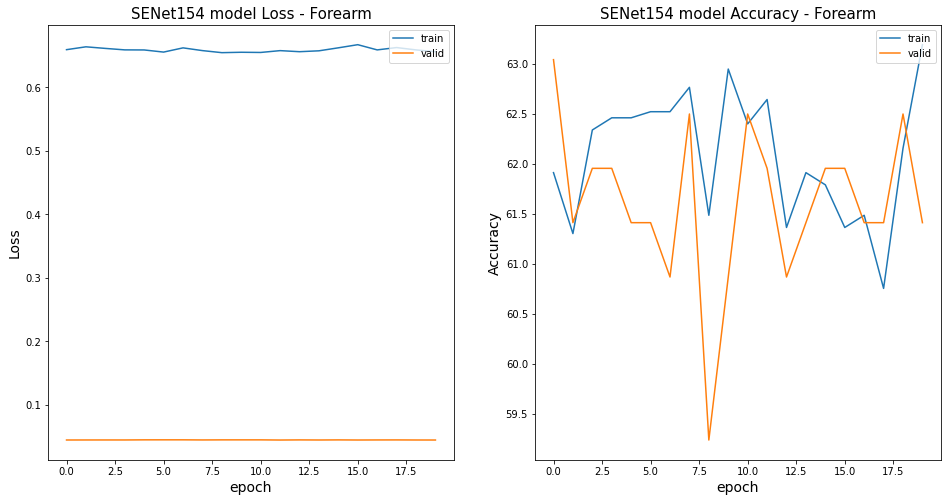

In [48]:
plot_training(train_acc,val_acc,train_loss,val_loss)